In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import stephane.Image_processing.tiff as tiff
import scipy.misc as misc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL.Image as Image
import scipy.ndimage.measurements as meas
import glob
import numpy as np
import stephane.tools.rw_data as rw_data
import stephane.tools.browse as browse
import stephane.display.graphes as graphes
import stephane.display.panel as panel
import stephane.manager.access as access
import stephane.elasticity.processing as proc
import stephane.elasticity.balloon as ball
import scipy
import stephane.hdf5.h5py_s as h5py_s
import glob
import numpy as np
import stephane.tools.rw_data as rw_data
import stephane.tools.browse as browse
import stephane.display.graphes as graphes
import stephane.display.panel as panel
import stephane.manager.access as access
import stephane.Image_processing.cine as cine
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
import stephane.Image_processing.tiff as tiff
import scipy.misc as misc
import matplotlib.pyplot as plt
import PIL.Image as Image
import scipy.ndimage.measurements as meas
import stephane.elasticity.processing as proc
import stephane.tools.Smath as Smath

In [3]:
ball.pressure(0.006,2*np.pi,20,R0=19)

3.0531401598262913

In [4]:
folder = '/Users/stephane/Documents/Postdoc_Princeton/Balloon/Interface_reconstruction/balloon_breakup_nopumps_fps10000_backlight_D800minch/'
D_0 = proc.load(folder,step=1)

In [5]:
D_0['fx'] = 0.122 #spatial scale, see reference.txt in the date folder
D_0['ft'] = 0.5 #time scale in ms
D_0['D'] = 0.8 * 25.4 #initial diameter in mm

In [17]:
D_0['im'] = np.transpose(D_0['im'],axes=(0,2,1))

In [42]:
D_0['im'] = D_0['im'][...,300:1000]

800

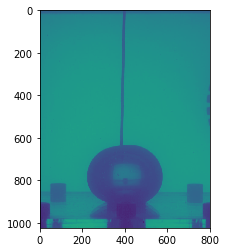

In [6]:
plt.imshow(D_0['im'][0,:,:])
D_0['L']

In [11]:
(nt,ny,nx)=D_0['im'].shape

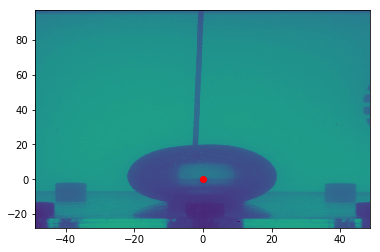

In [15]:
D_0['x']=(np.arange(0,nx)-400)*D_0['fx']
D_0['y']=(np.arange(ny,0,-1))*D_0['fx']-28
#print(D_0['x'].shape,D_0['y'].shape,D_0['im'].shape)
graphes.color_plot(D_0['x'],D_0['y'],D_0['im'][0,...])
graphes.graph([0],[0],label='ro')

In [25]:
N=200
nt=100
X = np.zeros((N,nt))
Y = np.zeros((N,nt))
for i in range(nt):
    print(i)
    X[:,i],Y[:,i] =interface(D_0,i,N=N,rmin=13,rmax=50,display=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [164]:
indices=np.where(np.logical_and(dl[:-1]>T,dl[1:]>T))

(array([  9,  87,  98, 150]),)

In [24]:
def interface(D,i,N=10**3,rmin=10,rmax=30,display=True):
    im0 = D['im'][i,...]
    x = D['x']
    y = D['y']
    X,Y = np.meshgrid(x,y)
    
    theta = np.concatenate((np.linspace(-0.2,np.pi/2-0.15,N/2),np.linspace(np.pi/2+0.15,np.pi+0.2,N/2)))
    
    grad = np.sum(np.asarray(np.gradient(im0))**2,axis=0)
    f = interp.interp2d(x,y,grad)

    nr = 120
    r= np.linspace(rmin,rmax,nr)
    
    R0 = np.zeros(N)
    for i,t in enumerate(theta):
        xi = r*np.cos(t)
        yi = r*np.sin(t)
        p = [f(xx,yy) for xx,yy in zip(xi,yi)]
        R0[i] = r[np.argmax(p)]

    xf = np.asarray(R0*np.cos(theta))
    yf = np.asarray(R0*np.sin(theta))

    if display:
        graphes.color_plot(X,Y,im0)
        graphes.graph(xf,yf,label='r.',fignum=1)
        graphes.graph(np.max(r)*np.cos(theta),np.max(r)*np.sin(theta),label='w--',fignum=1)
        graphes.graph(np.min(r)*np.cos(theta),np.min(r)*np.sin(theta),label='w--',fignum=1)
        plt.colorbar()
        graphes.legende('x (pix)','y (pix)','')
        
    return xf,yf

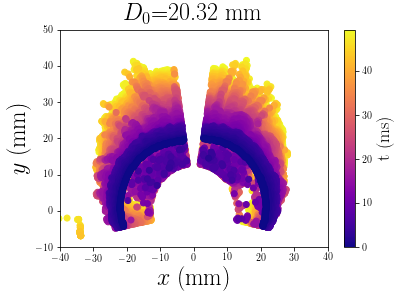

In [37]:
figs={}
nx,ny = X.shape
nt = 100
t = np.arange(nt)*D_0['ft']
for i,t0 in reversed(list(enumerate(t))):
    xf = X[:,i]
    yf = Y[:,i]
#    for j in range(3):
#        xf,yf = smooth(xf,yf,display=False,T=1.5)
#    plt.scatter(xf,yf,c=[tuple(np.tile([i/100.],3))],cmap='plasma')
    plt.scatter(xf,yf,cmap='plasma',c=np.tile([t0],nx),vmin=0,vmax=max(t))
plt.axis([-40,40,-10,50])
figs.update(graphes.legende('$x$ (mm)','$y$ (mm)','$D_0$='+str(D_0['D'])+' mm',cplot=True))
graphes.colorbar(label='t (ms)')
graphes.save_figs(figs,savedir='./Balloon/Interface_propagation/No_pump_final',frmt='png')

In [17]:
def smooth(xf,yf,T=2,display=False):
    dl = np.sqrt(np.diff(xf)**2+np.diff(yf)**2)
#graphes.graph(range(nx-1),dl,fignum=2,label='.')
#graphes.set_axis(0,200,0,5)
    indices=np.asarray(np.where(np.logical_and(dl[:-1]>T,dl[1:]>T)))

    xf[indices] = (np.asarray(xf[indices-1])+np.asarray(xf[indices+1]))/2 
    yf[indices] = (np.asarray(yf[indices-1])+np.asarray(yf[indices+1]))/2

    if display:
        plt.scatter(xf,yf,c=[tuple(np.tile([i/50.],3))],cmap='plasma')
    return xf,yf

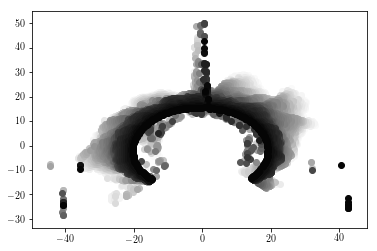

In [149]:
#plt.colorbar()
for i in range(50,0,-1):
    plt.scatter(X[:,i],Y[:,i],c=[tuple(np.tile([i/50.],3))],cmap='plasma',)
    graphes.legende('$x$ (mm)','$y$ (mm)','')
plt.colorbar()
#    plt.scatter(X[:,i],Y[:,i],c=[tuple(np.tile([0.5],3))],cmap='plasma',)

In [ ]:
graphes.graph(X[:,i],Y[:,i],label='.')

In [30]:
t = np.arange(nt)*D_0['ft']
[R,Theta] = Smath.cart2pol(X,Y)
Rmed = np.median(R,axis=0)
Rmoy = np.mean(R,axis=0)
Rstd = np.std(R,axis=0)

Data not saved


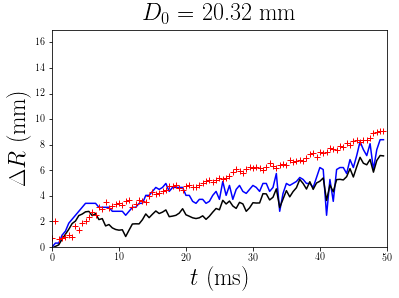

In [39]:
figs = {}
R0 = Rmed[0]
#R0=0
graphes.graph(t,Rmed-R0,label='b')
graphes.graph(t,Rmoy-R0,label='k')
graphes.graph(t,Rstd,label='r+')
graphes.set_axis(0,50,0,17)
figs.update(graphes.legende('$t$ (ms)','$\Delta R$ (mm)','$D_0$ = '+str(D_0['D'])+' mm'))
#figs.update(graphes.legende('$t$ (ms)','$<R^2>$ (mm)','$D_0$ = '+str(D_0['D'])+' mm'))
graphes.save_figs(figs,savedir='./Balloon/Interface_propagation/final_No_pump')

In [118]:
filename = folder + 'Data_test'
h5py_s.example(filename,Dict=D_0,key='D_0')

/Users/stephane/Documents/Postdoc_Princeton/Balloon/Interface_reconstruction/Balloon_backlight_fps10000_4pump12V_ceiling_2_D800minch_breaking_start/Data_test
D_0


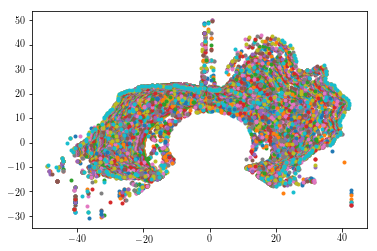

In [123]:
for i in range(100):
    graphes.graph(X[:,i],Y[:,i],label='.')

In [69]:
im0 = D_0['im'][0,...]
np.asarray(np.gradient(im0)).shape

(2, 800, 700)

In [220]:
np.concatenate((np.zeros(5),np.ones(5)))

array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.])

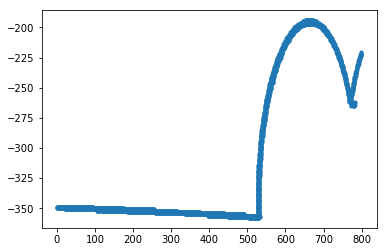

In [25]:
X,Y = proc.interface(D_0,0,T=12)
graphes.graph(Y,-X,label='.')

In [15]:
#estimate of the shear
U_0 = 30 #in m/s
t0 = 10**-3 # shear time in s
nu = 10**-6
delta = np.sqrt(nu*t0)
eta = U_0/(np.sqrt(np.pi)*delta)
print(eta)
print(delta)

535237.234846
3.16227766017e-05
